# Tx pool in EIP 1559

---


In [2]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

import pandas as pd
import numpy as np

In [3]:
class OptimisticUser(User1559):
    def expected_time(self, params):
        return 1

In [4]:
class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.
    
    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """

    epsilon = 0.1 # how much the user overbids by

    def expected_time(self, params):
        return 1

    def decide_parameters(self, params):
        if params["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = params["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

## (Bonus) Cancel culture

We now allow users to cancel their transactions. We discussed in the previous notebook's bonus section the concept of _ex post individual rationality_. Suppose I estimate that should my transaction be included within 5 blocks, my payoff will be positive. In this case, I decide to join the pool and send my transaction. Fierce competition during transitionary periods however might prevent me from being included when I thought I would be. Without the ability to cancel my transaction, I must stick around in the transaction pool and could net a negative payoff once I am included.

We add here the possibility for users to cancel their transaction. Cancelling is not completely trivial in the current, first-price auction paradigm (see [Etherscan's helpful guide for an overview](https://info.etherscan.com/how-to-cancel-ethereum-pending-transactions/)). To cancel transaction A, the trick is to send another transaction B with the same nonce (your address's "transaction counter") with a slightly higher fee. Miners with access to both A and B in their pool will strictly prefer B and _cannot_ include both.

With EIP 1559, we'll assume users send a new transaction with a slightly higher premium. We also assumed that miners keep around an extensible list of pending transactions, even those rendered invalid from a high basefee, in case the basefee decreases. So we'll assume that as soon as a user sends a replacement transaction to cancel its original transaction, the original transaction disappears from the mempool. The costs to users vary according to the outcome:

- In case the original and replacement transactions have a low gas price such that neither are ever included in a block, the user cancels "for free".
- On the other hand, when the replacement transaction is included, the user incurs a cost. It is rational to cancel whenever the payoff from cancelling the transaction is greater than the payoff from inclusion. Suppose the replacement transaction posts a premium equal to $p'$ (gas price = $g'$), while the original transaction's is $p$ (gas price = $g$). Cancelling yields a payoff of $-g'$, while being included yields $v - w . c - g$, where $v$ is the value, $c$ is the cost for waiting per block and $w$ is the time waited. It is rational to cancel whenever:

$$ v - w . c - g < -g' $$

Of course, $g$ and $g'$ both depend on the current basefee, which complicates the matter. To simplify here, we assume that as soon as the current value $v - w . c$ of the user becomes negative, the user cancels their transaction.

In [18]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
            "min_premium": min_premium,
            "cancel_cost": 2 * (10 ** 9), # in wei/gas
        }
        
        #########
        ## ADDED
        ##
        # We ask whether current users want to cancel their transactions waiting in the pool
        cancelled_txs = user_pool.cancel_transactions(txpool, params)        
        ##
        # Cancel transactions in the pool, adds new empty transactions with higher fee
        txpool.cancel_txs(cancelled_txs, params["cancel_cost"])
        ##
        #########
        
        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "cancelled_txs": len(cancelled_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [19]:
blocks = 200
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

In [20]:
df

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,cancelled_txs,blk_min_premium,pool_length
0,0,1.000000,2498,1249,1249,2170,952,0,1.1,1218
1,1,1.124900,2595,1297,1298,2242,952,0,1.2,2508
2,2,1.265400,2409,1204,1205,2086,952,37,1.3,3605
3,3,1.423448,2534,1267,1267,2122,952,57,1.4,4718
4,4,1.601237,2618,1309,1309,2190,952,84,1.5,5872
...,...,...,...,...,...,...,...,...,...,...
195,195,14.561289,2520,1260,1260,536,536,2,1.0,456
196,196,14.789901,2461,1230,1231,429,429,0,1.0,456
197,197,14.606691,2483,1241,1242,490,490,3,1.0,453
198,198,14.659640,2468,1234,1234,458,458,3,1.0,450


We observe a similar plot of basefee.

<AxesSubplot:xlabel='block'>

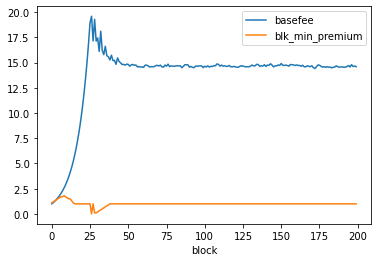

In [21]:
df.plot("block", ["basefee", "blk_min_premium"])

But we can now see the txpool slowly emptying, as users cancel their transactions.

<AxesSubplot:xlabel='block'>

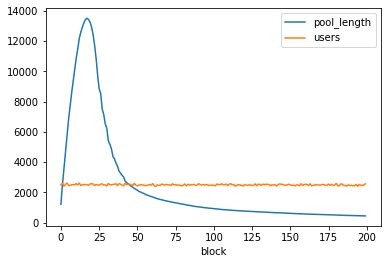

In [22]:
df.plot("block", ["pool_length", "users"])

Cancelled transactions are at their peak early in the simulation. During the basefee's transitionary period, many hopeful users find it profitable to send transactions in, believing they will be included quickly. But as basefee rises, they are priced out, and remain in the pool. Those with higher time-sensitivity see their current value decrease faster, and cancel early.

<AxesSubplot:xlabel='block'>

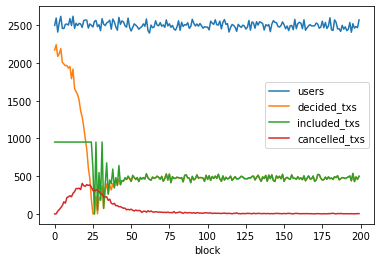

In [23]:
df.plot("block", ["users", "decided_txs", "included_txs", "cancelled_txs"])